In [1]:
% pylab inline
import tensorflow as tf
import numpy as np
# import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.contrib.kfac.python.ops.utils import fwd_gradients
import seaborn as sns
from utils import nn_l2_mean
slim = tf.contrib.slim
ds = tf.contrib.distributions
from universal_divergence import estimate

import os
os.environ["CUDA_VISIBLE_DEVICES"]="5"

Populating the interactive namespace from numpy and matplotlib


In [2]:
tf.reset_default_graph()

In [3]:
tf.set_random_seed(42)
np.random.seed(42)


### Generator and discriminator architectures

(same architecture as proposed in google brain paper)


In [4]:
def generator(z, output_dim=2, n_hidden=384, n_layer=6):
    with tf.variable_scope("generator"):
        h = slim.stack(z, slim.fully_connected, [n_hidden] * n_layer, activation_fn=tf.nn.relu)
        x = slim.fully_connected(h, output_dim, activation_fn=None)
    return x

def discriminator(x, n_hidden=384, n_layer=6, reuse=False):
    with tf.variable_scope("discriminator", reuse=reuse):
        h = slim.stack(x, slim.fully_connected, [n_hidden] * n_layer, activation_fn=tf.nn.relu)
        log_d = slim.fully_connected(h, 1, activation_fn=None)
    return log_d

### Data creation

In [5]:
def sample_mog(batch_size, n_mixture=16, std=0.2):
    x = np.linspace(-4.5,4.5,4)
    xs, ys = np.meshgrid(x, x)
    xs, ys = xs.flatten(), ys.flatten()
    cat = ds.Categorical(tf.zeros(n_mixture))
    comps = [ds.MultivariateNormalDiag([xi, yi], [std, std]) for xi, yi in zip(xs.ravel(), ys.ravel())]
    data = ds.Mixture(cat, comps)
    return data.sample(batch_size)

### Hyperparam

In [6]:
params = dict(
    batch_size=512,
    disc_learning_rate=1e-4,
    gen_learning_rate=1e-4,
    beta1=0.5,
    epsilon=1e-8,
    max_iter=20000,
    viz_every=2000,
    z_dim=256,
    x_dim=2,
    optimizer='rms-georgios', # rmsprop sgd sga
    lambd=1e-6
)

## Function for Symplectic gradient adjustment

## Construct model and training ops

In [7]:
tf.reset_default_graph()

data = sample_mog(params['batch_size'])
noise = ds.Normal(tf.zeros(params['z_dim']), tf.ones(params['z_dim'])).sample(params['batch_size'])

# Construct generator and discriminator nets
with slim.arg_scope([slim.fully_connected], weights_initializer=tf.orthogonal_initializer(gain=1.)):
    samples = generator(noise, output_dim=params['x_dim'])
    real_score = discriminator(data)
    fake_score = discriminator(samples, reuse=True)
    
# Saddle objective    
loss = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(logits=real_score, labels=tf.ones_like(real_score)) +
    tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_score, labels=tf.zeros_like(fake_score)))

gen_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "generator")
disc_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "discriminator")

if params['optimizer'] == 'rmsprop':
    print('sgd')
    g_train_opt = tf.train.RMSPropOptimizer(params['gen_learning_rate'])
    d_train_opt = tf.train.RMSPropOptimizer(params['disc_learning_rate'])
    d_train_op = d_train_opt.minimize(loss, var_list=disc_vars)
    g_train_op = g_train_opt.minimize(-loss, var_list=gen_vars)
    train_op = tf.group(g_train_op, d_train_op)

elif params['optimizer'] == 'sgd':    
    d_train_opt = tf.train.GradientDescentOptimizer(params['gen_learning_rate'])
    g_train_opt = tf.train.GradientDescentOptimizer(params['gen_learning_rate'])
    d_train_op = d_train_opt.minimize(loss, var_list=disc_vars)
    g_train_op = g_train_opt.minimize(-loss, var_list=gen_vars)
    train_op = tf.group(d_train_op,g_train_op)

elif params['optimizer'] == 'georgios': 
    print('georgios')

#     optimizer = tf.train.GradientDescentOptimizer(params['disc_learning_rate'])
    d_grads = tf.gradients(loss, disc_vars)
    g_grads = tf.gradients(-loss, gen_vars)
    
    variables = disc_vars + gen_vars
    grads = d_grads + g_grads
    
    var_updates = []
    for grad, var in zip(grads, variables):
        var_updates.append(var.assign_sub(params['disc_learning_rate'] * grad - params['lambd'] * var))
    train_op = tf.group(*var_updates)
    
elif params['optimizer'] == 'rms-georgios': 
    print('rms-georgios')
    d_opt = tf.train.RMSPropOptimizer(learning_rate=params['disc_learning_rate'])
    g_opt = tf.train.RMSPropOptimizer(learning_rate=params['gen_learning_rate'])
    
    optimizer = tf.train.RMSPropOptimizer(params['disc_learning_rate'], use_locking=True)
    
    d_grads = tf.gradients(loss, disc_vars)
    g_grads = tf.gradients(-loss, gen_vars)
    
    variables = disc_vars + gen_vars
    grads = d_grads + g_grads
    
    apply_vec = [(g - params['lambd'] * v, v)for (g, v) in zip(grads, variables)]
    
    with tf.control_dependencies([g for (g, v) in apply_vec]):
        train_op = optimizer.apply_gradients(apply_vec)
    
#     with tf.control_dependencies([g for (g, v) in apply_vec]):
#         train_op = optimizer.apply_gradients(apply_vec)
    

# elif params['optimizer'] == 'consensus': 
#     print('consensus')
#     d_opt = tf.train.RMSPropOptimizer(learning_rate=params['disc_learning_rate'])
#     g_opt = tf.train.RMSPropOptimizer(learning_rate=params['gen_learning_rate'])
    
#     optimizer = tf.train.RMSPropOptimizer(params['disc_learning_rate'], use_locking=True)

    
# #     dvs = d_opt.compute_gradients(loss, var_list=disc_vars)
# #     gvs = g_opt.compute_gradients(-loss, var_list=gen_vars)
    
#     d_grads = tf.gradients(loss, disc_vars)
#     g_grads = tf.gradients(-loss, gen_vars)
    
#     variables = disc_vars + gen_vars
#     grads = d_grads + g_grads
    

#     # Reguliarizer
#     reg = 0.5 * sum(tf.reduce_sum(tf.square(g)) for g in grads)
#     # Jacobian times gradiant
#     Jgrads = tf.gradients(reg, variables)
    
#     apply_vec = [(g + params['reg_w'] * Jg, v)for (g, Jg, v) in zip(grads, Jgrads, variables) if Jg is not None]
    
#     with tf.control_dependencies([g for (g, v) in apply_vec]):
#         train_op = optimizer.apply_gradients(apply_vec)

rms-georgios


## Train

In [8]:
# config = tf.ConfigProto(device_count={'GPU': 0})
# config.gpu_options.allow_growth = True
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

  0%|          | 0/20001 [00:00<?, ?it/s]

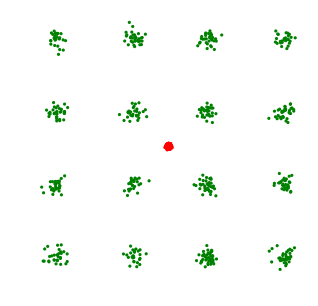

 10%|▉         | 1996/20001 [00:24<03:39, 82.02it/s]

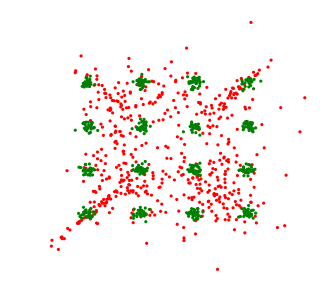

 20%|█▉        | 4000/20001 [00:48<03:09, 84.48it/s]

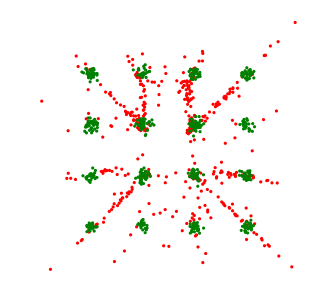

 30%|██▉       | 5995/20001 [01:12<02:49, 82.86it/s]

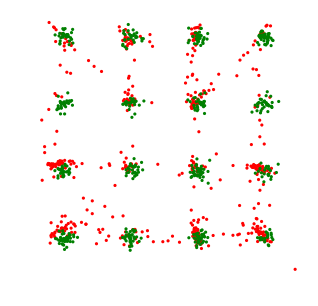

 40%|███▉      | 7996/20001 [01:35<02:18, 86.65it/s]

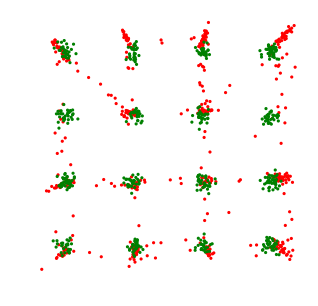

 50%|████▉     | 9997/20001 [01:59<01:55, 86.84it/s]

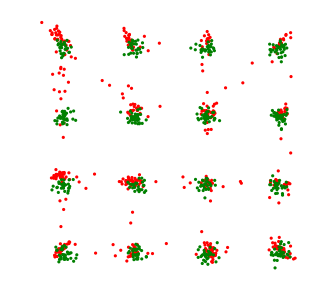

 60%|█████▉    | 11993/20001 [02:22<01:34, 84.47it/s]

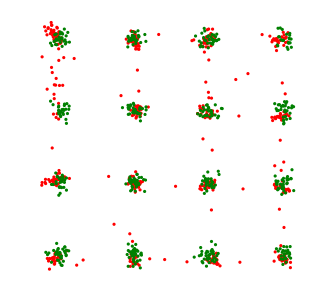

 70%|██████▉   | 14000/20001 [02:46<01:12, 82.38it/s]

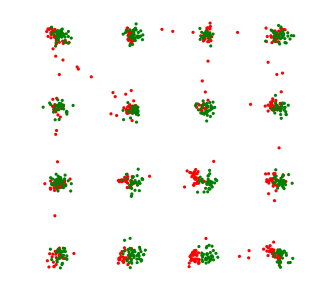

 80%|███████▉  | 15999/20001 [03:09<00:48, 82.53it/s]

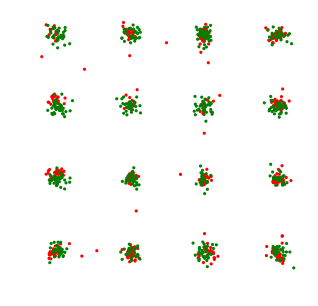

 90%|████████▉ | 17994/20001 [03:32<00:23, 86.82it/s]

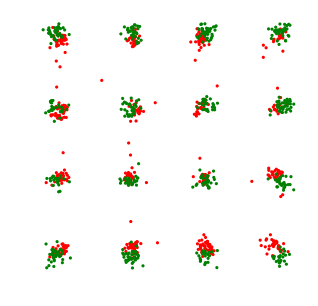

100%|█████████▉| 19995/20001 [03:56<00:00, 87.28it/s]

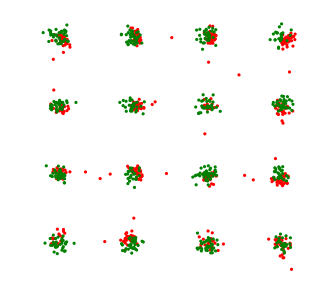

100%|██████████| 20001/20001 [03:56<00:00, 84.58it/s]


In [9]:
xmax = 3
fs = []
frames = []
np_samples = []
n_batches_viz = 10
viz_every = params['viz_every']
nn_every = 200
y_ref = sess.run( data)
nn_dist = []
nn_kl =[]
for i in tqdm(range(params['max_iter']+1)):
#     f, _, _ = sess.run([[loss], g_train_op, d_train_op])
    f, _= sess.run([[loss], train_op])

    fs.append(f)
    if (i) % viz_every == 0:
        np_samples.append(np.vstack([sess.run(samples) for _ in range(n_batches_viz)]))
        xx, yy = sess.run([samples, data])
        fig = figure(figsize=(5,5))
        scatter(xx[:, 0], xx[:, 1], c='r', edgecolor='none',s=10)
        scatter(yy[:, 0], yy[:, 1], c='g', edgecolor='none',s=10)
#         plt.xlim([-5.5, 5.5])
#         plt.ylim([-5.5, 5.5])
        axis('off')
        show()
        
#     if (i) % nn_every == 0:
#         x = np.vstack([sess.run(samples) for _ in range(n_batches_viz)])
#         l2nn = nn_l2_mean(x,y_ref)
#         kl =estimate(x, y_ref,k=1)
#         nn_dist.append(l2nn)
#         nn_kl.append(kl)
#         print('dist = ', l2nn)
#         print('kl = ', kl)

    

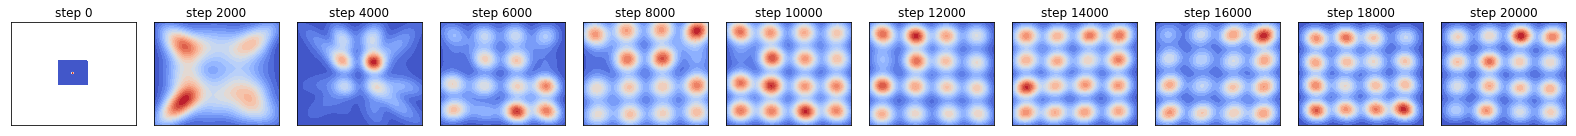

In [10]:
np_samples_ = np_samples[::1]
cols = len(np_samples_)
bg_color  = sns.color_palette('Greens', n_colors=256)[0]
figure(figsize=(2*cols, 2))
for i, samps in enumerate(np_samples_):
    if i == 0:
        ax = subplot(1,cols,1)
    else:
        subplot(1,cols,i+1, sharex=ax, sharey=ax)
#     ax2 = sns.kdeplot(samps[:, 0], samps[:, 1], shade=True, cmap='Greens', n_levels=20, clip=[[-6,6]]*2)
    ax2 = sns.kdeplot(samps[:, 0], samps[:, 1], shade=True, cmap='coolwarm',bw=.40, n_levels=20, clip=[[-6,6]]*2)

#     ax2.set_axis_bgcolor(bg_color)
    xticks([]); yticks([])
    title('step %d'%(i*viz_every))
gcf().tight_layout()

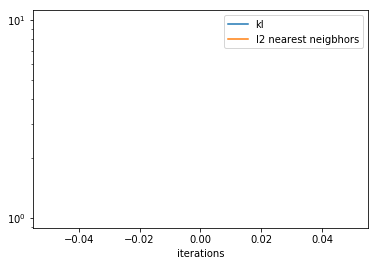

In [11]:
plt.semilogy(nn_dist)
plt.semilogy(nn_kl)
plt.legend(['kl','l2 nearest neigbhors'])
xlabel('iterations')
plt.show()

In [12]:
np.save('plot_con_kl',nn_kl)
np.save('plot_con_nn',nn_dist)